# Import thư viện

In [1]:
# Thư viện cơ bản
import pandas as pd
import numpy as np


# Thư viện vẽ biểu đồ
import matplotlib.pyplot as plt
import seaborn as sns

# Bỏ qua các cảnh báo
import warnings
warnings.filterwarnings('ignore')

# Thư viện tiền xử lý dữ liệu
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, label_binarize, RobustScaler
from imblearn.over_sampling import SMOTE
from sklearn.multiclass import OneVsRestClassifier

# Thư viện mô hình
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Thư viện đánh giá mô hình
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_curve, auc, confusion_matrix

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [2]:
train.head()

,Id,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,...,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response
0,2,1,D3,10,0.076923,2,1,1,0.641791,0.581818,...,0,0,0,0,0,0,0,0,0,8
1,5,1,A1,26,0.076923,2,3,1,0.059701,0.600000,...,0,0,0,0,0,0,0,0,0,4
2,6,1,E1,26,0.076923,2,3,1,0.029851,0.745455,...,0,0,0,0,0,0,0,0,0,8
3,7,1,D4,10,0.487179,2,3,1,0.164179,0.672727,...,0,0,0,0,0,0,0,0,0,8
4,8,1,D2,26,0.230769,2,3,1,0.417910,0.654545,...,0,0,0,0,0,0,0,0,0,8


In [3]:
# Tập train chiếm 75% dữ liệu
train.shape

(59381, 128)

In [4]:
test.head()

,Id,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,...,Medical_Keyword_39,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48
0,1,1,D3,26,0.487179,2,3,1,0.611940,0.781818,...,0,0,0,0,0,0,0,0,0,0
1,3,1,A2,26,0.076923,2,3,1,0.626866,0.727273,...,0,0,0,0,0,0,0,0,0,0
2,4,1,D3,26,0.144667,2,3,1,0.582090,0.709091,...,0,0,0,0,0,0,0,0,0,0
3,9,1,A1,26,0.151709,2,1,1,0.522388,0.654545,...,0,0,0,0,0,0,0,0,1,1
4,12,1,A1,26,0.076923,2,3,1,0.298507,0.672727,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# Tập test chiếm 25% dữ liệu
test.shape

(19765, 127)

# Tiền xử lý tập train

In [6]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,59381.0,39507.211515,22815.883089,2.0,19780.000000,39487.000000,59211.000000,79146.0
Product_Info_1,59381.0,1.026355,0.160191,1.0,1.000000,1.000000,1.000000,2.0
Product_Info_3,59381.0,24.415655,5.072885,1.0,26.000000,26.000000,26.000000,38.0
Product_Info_4,59381.0,0.328952,0.282562,0.0,0.076923,0.230769,0.487179,1.0
Product_Info_5,59381.0,2.006955,0.083107,2.0,2.000000,2.000000,2.000000,3.0
...,...,...,...,...,...,...,...,...
Medical_Keyword_45,59381.0,0.013691,0.116207,0.0,0.000000,0.000000,0.000000,1.0
Medical_Keyword_46,59381.0,0.008488,0.091737,0.0,0.000000,0.000000,0.000000,1.0
Medical_Keyword_47,59381.0,0.019905,0.139676,0.0,0.000000,0.000000,0.000000,1.0
Medical_Keyword_48,59381.0,0.054496,0.226995,0.0,0.000000,0.000000,0.000000,1.0


In [7]:
train['Response'].value_counts()

Response
8    19489
6    11233
7     8027
2     6552
1     6207
5     5432
4     1428
3     1013
Name: count, dtype: int64

In [8]:
train['Response'].value_counts() / len(train) * 100

Response
8    32.820262
6    18.916825
7    13.517792
2    11.033832
1    10.452838
5     9.147707
4     2.404810
3     1.705933
Name: count, dtype: float64

<Axes: xlabel='Response', ylabel='count'>

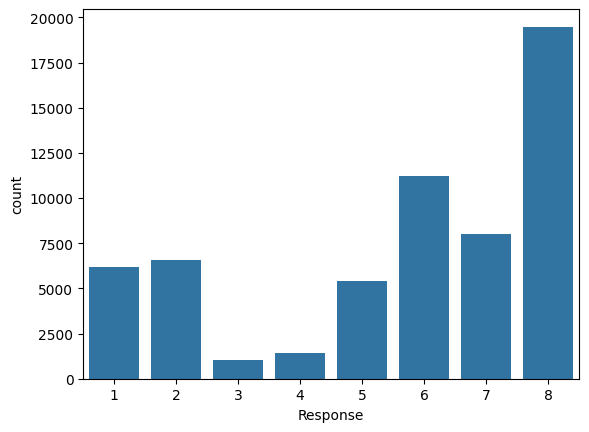

In [9]:
# Biểu đồ phân phối nhãn
sns.countplot(x = train['Response'])

# Nhãn phân phối khá lệch

In [10]:
# Gộp nhãn mới như sau:
# Rủi ro thấp: 1, 2, 3, 4, 5, 6 = 0
# Rủi ro trung bình: 7, 8 = 1
def map_response(x):
    if x in [1, 2, 3, 4, 5, 6]:
        return 0
    else:
        return 1
train['Response'] = train['Response'].map(map_response)

In [11]:
train['Response'].value_counts()

Response
0    31865
1    27516
Name: count, dtype: int64

In [12]:
train['Response'].value_counts() / len(train) * 100

Response
0    53.661946
1    46.338054
Name: count, dtype: float64

<Axes: xlabel='Response', ylabel='count'>

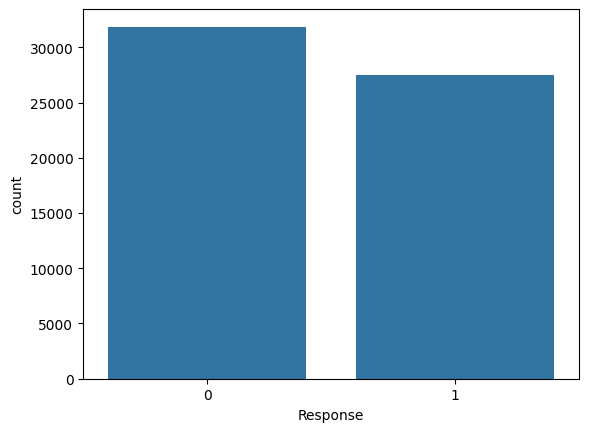

In [13]:
# Nhãn đã được phân phối lại
sns.countplot(x = train['Response'])

In [14]:
le = LabelEncoder()
# Chuyển cột định tính thành định lượng
train['Product_Info_2'] = le.fit_transform(train['Product_Info_2'])

In [15]:
# Drop cột không cần thiết
train.drop(columns=['Id'], inplace=True)

In [16]:
# Xem các cột null trong tập train
train_null_cols = train.isnull().sum()[train.isnull().sum() > 0]
train_null_cols

Employment_Info_1         19
Employment_Info_4       6779
Employment_Info_6      10854
Insurance_History_5    25396
Family_Hist_2          28656
Family_Hist_3          34241
Family_Hist_4          19184
Family_Hist_5          41811
Medical_History_1       8889
Medical_History_10     58824
Medical_History_15     44596
Medical_History_24     55580
Medical_History_32     58274
dtype: int64

In [17]:
# Xem tỉ lệ các cột null trong tập train
train_null_cols / len(train) * 100

Employment_Info_1       0.031997
Employment_Info_4      11.416110
Employment_Info_6      18.278574
Insurance_History_5    42.767889
Family_Hist_2          48.257860
Family_Hist_3          57.663226
Family_Hist_4          32.306630
Family_Hist_5          70.411411
Medical_History_1      14.969435
Medical_History_10     99.061990
Medical_History_15     75.101463
Medical_History_24     93.598963
Medical_History_32     98.135767
dtype: float64

In [18]:
# Drop tất cả cột có tỉ lệ null >= 50%
train = train.loc[:, train.isnull().mean() < 0.5]

In [19]:
# Fill null với trung vị
train = train.fillna(train.median())

# Tiền xử lý tập test

In [20]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,19765.0,39772.653883,22942.157493,1.0,19792.000000,39898.000000,59758.000000,79129.0
Product_Info_1,19765.0,1.024994,0.156110,1.0,1.000000,1.000000,1.000000,2.0
Product_Info_3,19765.0,24.321730,5.184879,2.0,26.000000,26.000000,26.000000,37.0
Product_Info_4,19765.0,0.324381,0.279439,0.0,0.076923,0.230769,0.487179,1.0
Product_Info_5,19765.0,2.006527,0.080526,2.0,2.000000,2.000000,2.000000,3.0
...,...,...,...,...,...,...,...,...
Medical_Keyword_44,19765.0,0.008247,0.090440,0.0,0.000000,0.000000,0.000000,1.0
Medical_Keyword_45,19765.0,0.013559,0.115655,0.0,0.000000,0.000000,0.000000,1.0
Medical_Keyword_46,19765.0,0.008601,0.092345,0.0,0.000000,0.000000,0.000000,1.0
Medical_Keyword_47,19765.0,0.018315,0.134092,0.0,0.000000,0.000000,0.000000,1.0


In [21]:
# Chuyển cột định tính thành định lượng với thông tin đã huấn luyện từ tập train
test['Product_Info_2'] = le.transform(test['Product_Info_2'])

In [22]:
# Drop cột không cần thiết
test.drop(columns=['Id'], inplace=True)

In [23]:
# Xem các cột null trong tập test
test_null_cols = test.isnull().sum()[test.isnull().sum() > 0]
test_null_cols

Employment_Info_1          3
Employment_Info_4       2137
Employment_Info_6       3787
Insurance_History_5     8105
Family_Hist_2           9880
Family_Hist_3          11064
Family_Hist_4           6677
Family_Hist_5          13624
Medical_History_1       2972
Medical_History_10     19564
Medical_History_15     14864
Medical_History_24     18585
Medical_History_32     19414
dtype: int64

In [24]:
# Xem tỉ lệ các cột null trong tập test
test_null_cols / len(test) * 100

Employment_Info_1       0.015178
Employment_Info_4      10.812041
Employment_Info_6      19.160132
Insurance_History_5    41.006830
Family_Hist_2          49.987351
Family_Hist_3          55.977738
Family_Hist_4          33.781938
Family_Hist_5          68.929927
Medical_History_1      15.036681
Medical_History_10     98.983051
Medical_History_15     75.203643
Medical_History_24     94.029851
Medical_History_32     98.224134
dtype: float64

In [25]:
# Drop tất cả cột có tỉ lệ null >= 50%
test = test.loc[:, test.isnull().mean() < 0.5]

In [26]:
# Fill null với trung vị
test = test.fillna(test.median())

# Chia Train, Validation

- Lí do chia tập dữ liệu train thành train và valid là do tập test không có nhãn
- => phải huấn luyện và kiểm tra trên train và valid sau đó đưa dự đoán vào test

In [27]:
# Tách dữ liệu: X - thuộc tính | y - nhãn
X = train.drop(['Response'], axis=1)
y = train['Response']

In [28]:
# Sau khi chia dữ liệu: Train - 60%, Validation - 15%, Test - 25%
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1/5, random_state=42, stratify=y)
# Khi này X_test chính là tập test
X_test = test

In [29]:
# smote = SMOTE(random_state=42)
# X_train, y_train = smote.fit_resample(X_train, y_train)

In [30]:
# robust = RobustScaler()
# X_train = robust.fit_transform(X_train)
# X_val = robust.transform(X_val)
# X_test = robust.transform(X_test)

In [31]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape

((47504, 120), (47504,), (11877, 120), (11877,), (19765, 120))

# Chạy mô hình

- Lựa chọn mô hình Decision Tree 
## Lí do:
+ Dễ trực quan hóa bằng sơ đồ cây => dễ giải thích
+ Không sợ ngoại lai vì chia nhánh dựa trên độ hỗn loạn và độ tăng thông tin
+ Chống overfitting dễ dàng bằng cách điều chỉnh độ sâu tối đa, số lá tối thiểu, ...

In [32]:
clf_dt = DecisionTreeClassifier(random_state=42, max_depth=6,class_weight='balanced')

# Huấn luyện mô hình
clf_dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=6, random_state=42)

In [33]:
# Dự đoán trên tập validation
y_pred = clf_dt.predict(X_val)

In [35]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.77      0.79      6373
           1       0.75      0.79      0.77      5504

    accuracy                           0.78     11877
   macro avg       0.78      0.78      0.78     11877
weighted avg       0.78      0.78      0.78     11877



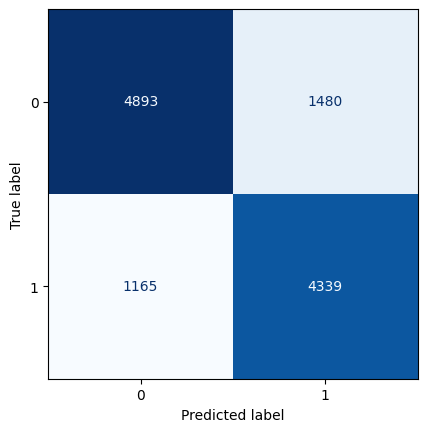

In [36]:
# Ma trận nhầm lẫn
ConfusionMatrixDisplay.from_estimator(clf_dt, X_val, y_val, cmap='Blues', colorbar=False)

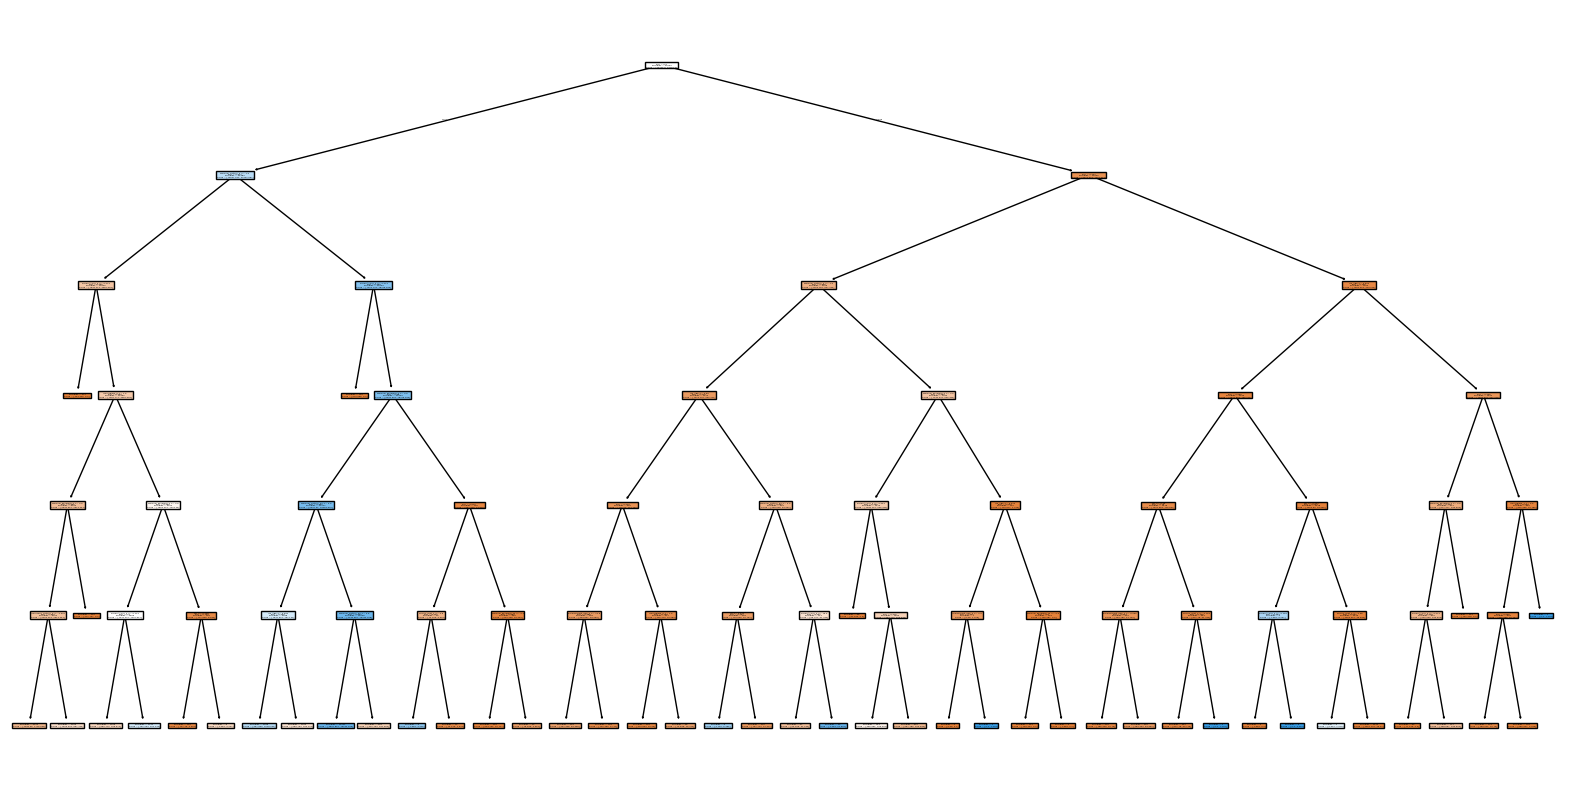

In [38]:

plt.figure(figsize=(20,10))
plot_tree(clf_dt, feature_names=train.columns[:-1], filled=True)
plt.show()

# Cây chưa tối ưu

# Tối ưu mô hình

## Dùng GridSearchCV để tìm parameter
Lí do:
- Tối ưu toàn diện nhiều yếu tố: max_depth, min_samples_split, min_samples_leaf, max_leaf_nodes, ...
- Các tham số trên trực tiếp ảnh hưởng đến độ sâu và độ phức tạp => tránh overfit/underfit
- Có thể kết hợp cross-validation
- Hợp với dữ liệu nhiều feature

In [39]:
param_grid = {
    'criterion': ['gini','entropy'],                       # Tiêu chí chia nhánh
    'max_depth': [4, 6, 8],                        # Giới hạn độ sâu
    'min_samples_split': [2, 4, 8],                        # Số mẫu tối thiểu để split
    'min_samples_leaf': [1, 2, 4],                            # Số mẫu tối thiểu trong mỗi lá
    'max_features': ['sqrt', 'log2'],                       # Số lượng thuộc tính tối đa để chia nhánh
    'class_weight': [None, 'balanced']                      # Cân bằng nhãn trong loss
}

In [ ]:
grid_search = GridSearchCV(
    estimator=clf_dt,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              max_depth=6, random_state=42),
             n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 6, 8],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 4, 8]},
             verbose=1)

In [39]:
best_param = grid_search.best_params_

In [40]:
best_estimator = grid_search.best_estimator_

In [41]:
best_dt = DecisionTreeClassifier(**best_param, random_state=42)
best_dt.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=6, max_features='sqrt',
                       min_samples_leaf=2, min_samples_split=4,
                       random_state=42)

In [42]:
y_pred_best = best_estimator.predict(X_val)

In [43]:
print(classification_report(y_val, y_pred_best))

              precision    recall  f1-score   support

           0       0.74      0.70      0.72      6373
           1       0.68      0.72      0.70      5504

    accuracy                           0.71     11877
   macro avg       0.71      0.71      0.71     11877
weighted avg       0.71      0.71      0.71     11877



<Figure size 800x600 with 0 Axes>

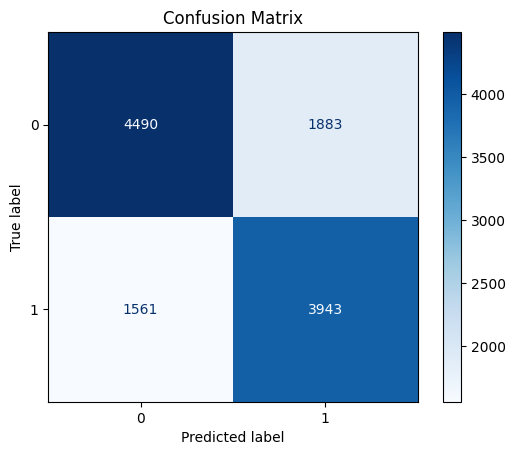

In [44]:
cm = confusion_matrix(y_val, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_estimator.classes_)

plt.figure(figsize=(8,6))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

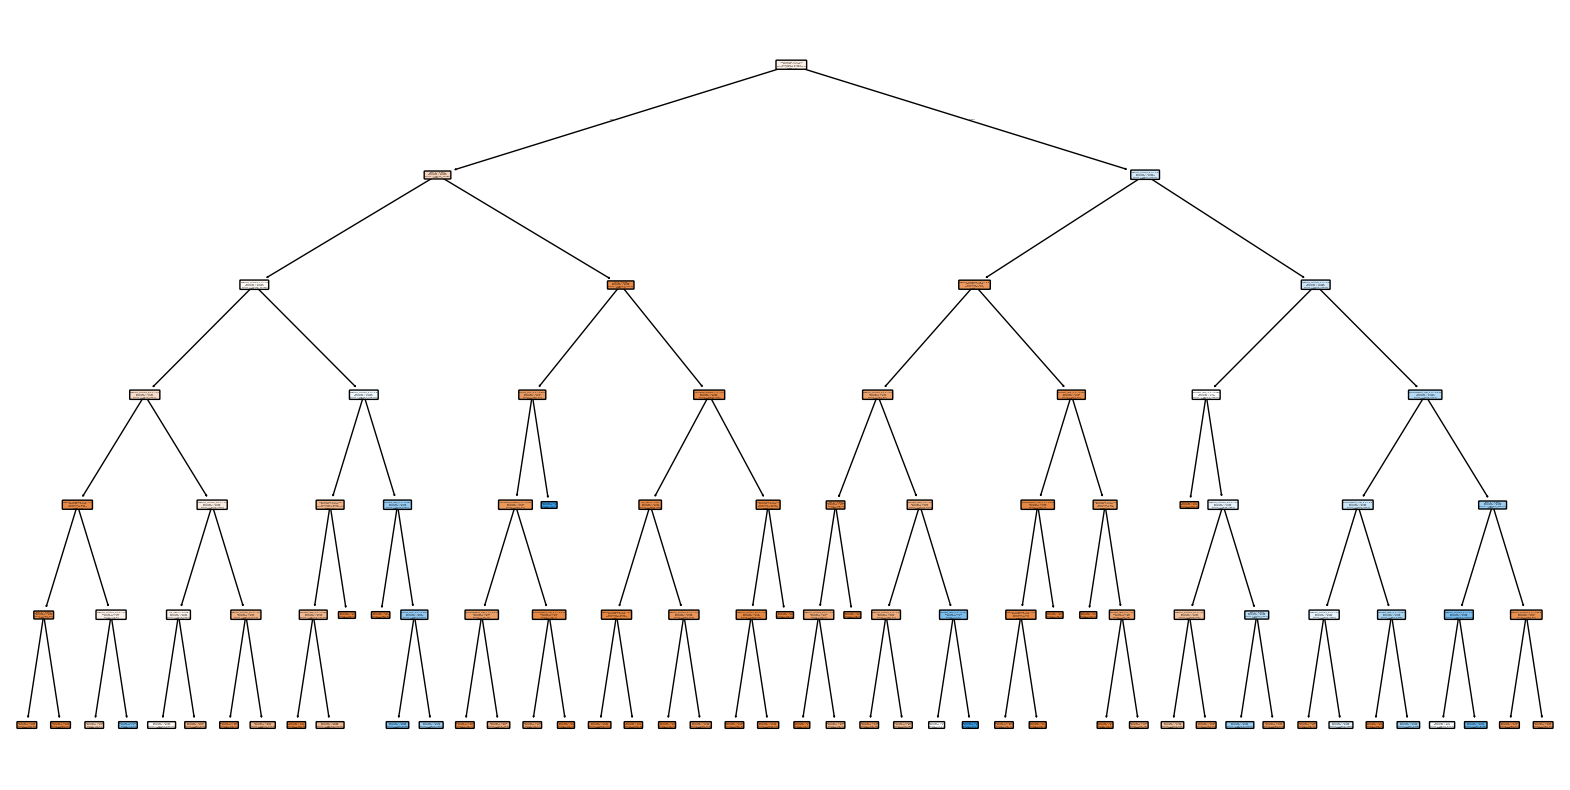

In [46]:
plt.figure(figsize=(20,10))
plot_tree(best_dt, filled=True, feature_names=train.columns[:-1], class_names=['0', '1'], rounded=True)
plt.show()